In [8]:
import numpy as np
import pandas as pd
import torch
import os
import joblib
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from collections import Counter
# 引入配置和模型
import config 
# 确保 models 里的 LSTMFeatureExtractor 是最新的（带 fc_final 的版本）
from models import LSTMFeatureExtractor 
from utility_uad_svm import load_data, create_sequences_for_svm, get_features

In [9]:
def clean_features(F_feat):
    """清除特征中的 NaN 和 Inf 值。"""
    nan_count = np.sum(np.isnan(F_feat))
    inf_count = np.sum(np.isinf(F_feat))
    if nan_count > 0 or inf_count > 0:
        print(f"【⚠️ 清理】发现 {nan_count} NaN / {inf_count} Inf。正在修复...")
        F_feat = np.nan_to_num(F_feat, nan=0.0, posinf=1e8, neginf=-1e8) 
    return F_feat

In [10]:
def complex_balance_data(X_feat, y_labels, sat_types, random_state=42):
    """
    【关键修改】基于 标签(y) 和 卫星类型(sat_type) 进行四象限平衡。
    确保 GNSS/PL 的 好/坏 信号在 SVM 训练集中比例一致。
    """
    print(f"  - [平衡前] 总体分布: {Counter(y_labels)}")
    
    # 构建临时 DataFrame 方便索引
    df_temp = pd.DataFrame({
        'idx': range(len(X_feat)), 
        'y': y_labels, 
        'sat': sat_types
    })
    
    # 1. 划分四类人群
    # 假设 sat_type: 0=GNSS, 1=PL; y: 0=LOS(好), 1=Multipath(坏)
    idx_gnss_good = df_temp[(df_temp['sat'] == 0) & (df_temp['y'] == 0)]['idx'].values
    idx_gnss_bad  = df_temp[(df_temp['sat'] == 0) & (df_temp['y'] == 1)]['idx'].values
    idx_pl_good   = df_temp[(df_temp['sat'] == 1) & (df_temp['y'] == 0)]['idx'].values
    idx_pl_bad    = df_temp[(df_temp['sat'] == 1) & (df_temp['y'] == 1)]['idx'].values
    
    print(f"  - 组别统计: GNSS好:{len(idx_gnss_good)}, GNSS坏:{len(idx_gnss_bad)}, PL好:{len(idx_pl_good)}, PL坏:{len(idx_pl_bad)}")
    
    # 2. 找到短板（最小数量）
    # 注意：如果某一组是 0，需要特殊处理
    counts = [len(idx_gnss_good), len(idx_gnss_bad), len(idx_pl_good), len(idx_pl_bad)]
    counts = [c for c in counts if c > 0] # 过滤掉 0
    if not counts:
        return np.empty((0, X_feat.shape[1])), np.empty((0,))
        
    min_size = min(counts)
    print(f"  - 平衡基准数 (min_size): {min_size}")
    
    
    # 3. 欠采样函数
    def sample_indices(indices, n):
        if len(indices) == 0: return indices
        np.random.seed(random_state)
        return np.random.choice(indices, n, replace=False)

    # 4. 执行采样
    final_indices = np.concatenate([
        sample_indices(idx_gnss_good, min_size),
        sample_indices(idx_gnss_bad, min_size),
        sample_indices(idx_pl_good, min_size),
        sample_indices(idx_pl_bad, min_size)
    ])
    
    np.random.shuffle(final_indices)
    
    return X_feat[final_indices], y_labels[final_indices]

In [11]:
# def standardize_features_global(F_src, F_tgt):
#     """
#     对特征进行标准化。
#     逻辑：在源域上 Fit，应用到源域和目标域。
#     """
#     print("  - 执行特征标准化 (Z-Score)...")
#     scaler = StandardScaler()
#     scaler.fit(F_src) # 只在源域上学习均值和方差
    
#     # 防御标准差为 0
#     zero_std_mask = scaler.scale_ == 0
#     if np.any(zero_std_mask):
#         scaler.scale_[zero_std_mask] = 1e-8
        
#     F_src_scaled = scaler.transform(F_src)
#     F_tgt_scaled = scaler.transform(F_tgt)
#     return F_src_scaled, F_tgt_scaled

def standardize_features_global(F_src, F_tgt):
    print("  - 执行特征标准化 (Z-Score)...")
    scaler = StandardScaler()
    scaler.fit(F_src) # 计算源域的均值和方差
    
    # --- 🔍 强力调试与修复 ---
    print(f"  - [调试] 特征均值前5位: {scaler.mean_[:5]}")
    print(f"  - [调试] 特征方差前5位: {scaler.var_[:5]}")
    
    # 检查方差是否极小 (接近0)
    # 注意：StandardScaler 内部用 var_, 如果 var_ 为 0，scale_ 也会出问题
    zero_var_mask = scaler.var_ < 1e-8 # 使用一个极小阈值
    if np.any(zero_var_mask):
        num_dead = np.sum(zero_var_mask)
        print(f"【⚠️ 严重警告】发现 {num_dead} 个特征维度方差几乎为 0 (死神经元)！")
        # 强制把这些维度的方差设为 1，防止除以 0 (这样 x-mean 后结果就是 0，不会是 NaN)
        scaler.var_[zero_var_mask] = 1.0 
        scaler.scale_[zero_var_mask] = 1.0 
    
    F_src_scaled = scaler.transform(F_src)
    F_tgt_scaled = scaler.transform(F_tgt)
    
    return F_src_scaled, F_tgt_scaled

In [12]:
SRC_IDS = config.SRC_IDS
TGT_ID = config.TGT_ID
CSV_PATHS = config.CSV_PATHS

--- [SVM Main] 正在使用设备: cpu ---

--- [步骤 1] 加载原始数据 ---
[load_data] 正在加载目标域数据: 0
[load_data] 目标域加载完成。形状: (12614, 14)
[load_data] 注：源域数据将在 'create_all_sequences' 中逐个加载以保证时序独立性。

--- [步骤 1.5] 标准化 (加载 DANN 训练时的参数) ---

--- [步骤 2] 制作序列 ---

--- [序列制作] 正在创建 SVM 所需的序列 (逐个Case处理)... ---
  - 处理源域 Case 1: Case1_Urban_10Hz_with_sat_type.csv
  - X 形状: (91655, 5, 5), y 形状: (91655,), S 形状: (91655,)
  - 处理源域 Case 2: Case1_Suburban_10Hz_with_sat_type.csv
  - X 形状: (91655, 5, 5), y 形状: (91655,), S 形状: (91655,)
  - 处理源域 Case 3: Case2_Urban_10Hz_with_sat_type.csv
  - X 形状: (79792, 5, 5), y 形状: (79792,), S 形状: (79792,)
  - 处理源域 Case 4: Case2_Suburban_10Hz_with_sat_type.csv
  - X 形状: (79830, 5, 5), y 形状: (79830,), S 形状: (79830,)
  - 处理源域 Case 5: Case3_Urban_10Hz_with_sat_type.csv
  - X 形状: (91654, 5, 5), y 形状: (91654,), S 形状: (91654,)
  - 处理源域 Case 6: Case3_Suburban_10Hz_with_sat_type.csv
  - X 形状: (91655, 5, 5), y 形状: (91655,), S 形状: (91655,)
  - 处理源域 Case 7: Case4_Urban_10Hz_with_sat_type.csv
  - X 形状: (9

  - 提取特征中: 100%|██████████| 11087/11087 [00:50<00:00, 218.39it/s]


  - 特征提取完毕。输出形状: (709551, 128)
【✅ 正常】原始特征里没有 NaN。问题出在标准化步骤。
  - 正在执行特征提取...


  - 提取特征中: 100%|██████████| 196/196 [00:00<00:00, 234.99it/s]


  - 特征提取完毕。输出形状: (12538, 128)
  - 源域特征形状: (709551, 128)

--- [步骤 4] 特征标准化 ---
  - 执行特征标准化 (Z-Score)...
  - [调试] 特征均值前5位: [0.19415551 0.11543466 0.17720987 0.41237124 0.25024576]
  - [调试] 特征方差前5位: [0.12859521 0.10804579 0.07636821 0.23257125 0.29910736]

--- [步骤 5] 数据平衡与 SVM 训练 ---
  - [平衡前] 总体分布: Counter({np.int64(1): 376352, np.int64(0): 333199})
  - 组别统计: GNSS好:102795, GNSS坏:343067, PL好:230404, PL坏:33285
  - 平衡基准数 (min_size): 33285
  - 数据量 133140 > 20000，进行二次随机采样...
  - 最终 SVM 训练集大小: (20000, 128)
  - 开始训练 SVM (RBF Kernel)...
✅ SVM 训练完成。

--- [步骤 6] 目标域预测与阈值校准 ---
  - 剔除 sat_type=-1 后，剩余目标域样本数: 12538
✅ 分数分布图已保存至: c:\Users\yangj\Desktop\GNSS-main\GNSS-main\Transfer Learning\SVM\checkpoints\svm_score_distribution.png
🔴 请打开这张图！观察大部分数据分布在 0 的左边还是右边。

--- [预测] 启用方案 B: 强制对齐 Aachen 环境比例 ---
  - [诊断] 分数标准差 (Std): 0.809839
  - 目标坏信号比例: 20%
  - 校准后的新阈值: 0.2758
  - [最终结果] 预测为坏信号(1)的比例: 20.00%
  - [最终结果] 预测为好信号(0)的比例: 80.00%

--- [步骤 7] 保存结果 ---
✅ 结果已保存至: c:\Users\yangj\Desktop\GNSS-main\GNSS-mai

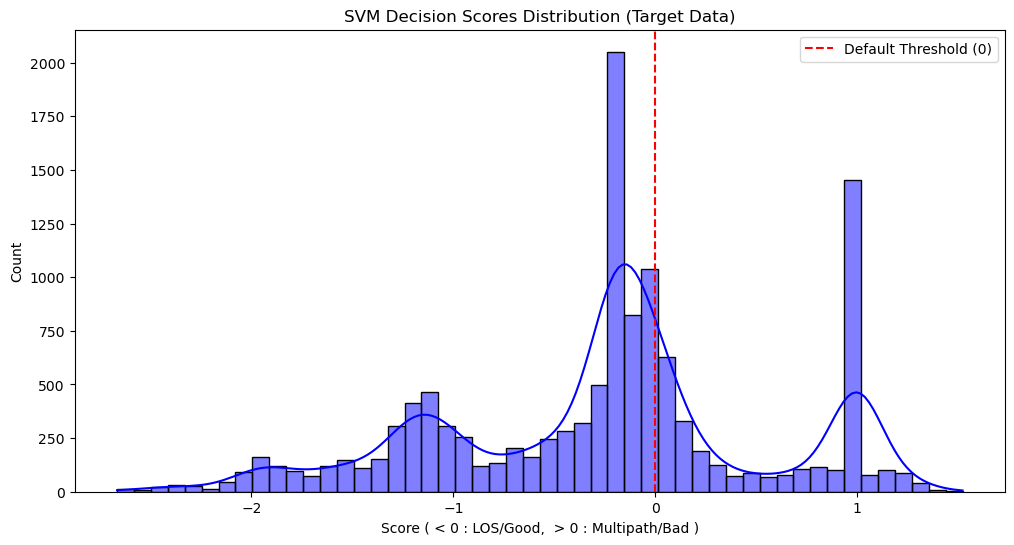

In [13]:
# =============================================================================
# 主程序
# =============================================================================
from utility_uad_svm import lstm_standardization_train_pre_svm
import matplotlib.pyplot as plt
import seaborn as sns
def main_single_svm():
    device = torch.device(config.DEVICE)
    print(f"--- [SVM Main] 正在使用设备: {device} ---")
    
    # -------------------------------------------------------
    # 1. 加载数据 & 原始数据标准化 (必须与 DANN 训练时一致!)
    # -------------------------------------------------------
    print("\n--- [步骤 1] 加载原始数据 ---")
    df_src, df_tgt = load_data(SRC_IDS, TGT_ID, CSV_PATHS)
    if df_tgt is None: 
        print("目标域加载失败")
        return
    # 目标域预处理 (清洗)
    if df_tgt.isnull().values.any():
        df_tgt = df_tgt.fillna(0)
    df_tgt = df_tgt.replace([np.inf, -np.inf], 0)
    # # 【重要提示】如果 DANN 训练时对原始数据做了标准化，这里必须做。
    # # 如果 DANN 训练时没做，请注释掉下面这几行！
    # print("  - [提示] 正在对原始输入信号进行标准化 (假设 DANN 训练时也做了)...")
    # raw_scaler = StandardScaler()
    # # fit on source
    # df_src[config.FEATURES] = raw_scaler.fit_transform(df_src[config.FEATURES])
    # # transform target
    # df_tgt[config.FEATURES] = raw_scaler.transform(df_tgt[config.FEATURES])
    # print("✅ 原始数据预处理完成。")
    df_tgt_raw_backup = df_tgt.copy()
    # ... 在 main_single_svm 函数里 ...

    print("\n--- [步骤 1.5] 标准化 (加载 DANN 训练时的参数) ---")

    # # 1. 对源域 (SVM 训练数据，提取特征前)#########这个位置的标准化 放到utility 里面 直接和create_sequences_for_svm 结合了
    # df_src = lstm_standardization_train_pre_svm(
    #     df_src, 
    #     config.FEATURES, 
    #     config.MODEL_SAVE_DIR
    # )
    # 2. 对目标域 (真实推理数据，提取特征前)
    df_tgt = lstm_standardization_train_pre_svm(
        df_tgt, 
        config.FEATURES, 
        config.MODEL_SAVE_DIR
    )
    # -------------------------------------------------------
    # 2. 制作序列 (需要获取 S_src 用于平衡)
    # -------------------------------------------------------
    print("\n--- [步骤 2] 制作序列 ---")
    # 注意：create_sequences_for_svm 需要返回 S_src (卫星类型)
    #X_src, y_src, S_src, I_src_raw, X_tgt, y_tgt, S_tgt, TGT_INDICES = create_sequences_for_svm(df_src, df_tgt, config)
    results = create_sequences_for_svm(df_src, df_tgt, config)
    if results[0] is None: return
    X_src, y_src, S_src, I_src_raw, X_tgt, y_tgt, S_tgt, TGT_INDICES = results
    print("--- [数据分布检查] ---")
    from collections import Counter
    print(f"目标域卫星分布: {Counter(S_tgt)}")
    if X_src is None: return

    # -------------------------------------------------------
    # 3. 加载特征提取器 (G_f)
    # -------------------------------------------------------
    print("\n--- [步骤 3] 加载 G_f 模型并提取特征 ---")
    # ！！请确保这里的参数与 models.py 中的定义一致！！
    # 如果 models.py 里加了 final_feature_dim，这里也要确认默认值是否匹配
    G_f = LSTMFeatureExtractor(
        input_size=config.LSTM_INPUT_SIZE,
        hidden_size=config.LSTM_HIDDEN_SIZE,
        num_layers=config.LSTM_NUM_LAYERS,
        dropout=config.LSTM_DROPOUT
    ).to(device)

    G_f_path = os.path.join(config.MODEL_SAVE_DIR, "G_f_final.pth")
    if not os.path.exists(G_f_path):
        print(f"❌ 错误：找不到模型文件 {G_f_path}")
        return
        
    G_f.load_state_dict(torch.load(G_f_path, map_location=device))
    G_f.eval() # 必须是 eval 模式！

    # 提取特征 (Raw Features)
    F_src_raw = get_features(G_f, X_src, config.BATCH_SIZE, device)
    if np.isnan(F_src_raw).any():
        print("【💥 爆炸】LSTM 提取出的原始特征里就已经有 NaN 了！模型训练废了！")
    else:
        print("【✅ 正常】原始特征里没有 NaN。问题出在标准化步骤。")
    F_tgt_raw = get_features(G_f, X_tgt, config.BATCH_SIZE, device)
    
    print(f"  - 源域特征形状: {F_src_raw.shape}")

    # -------------------------------------------------------
    # 4. 特征标准化 (Feature Standardization)
    # -------------------------------------------------------
    print("\n--- [步骤 4] 特征标准化 ---")
    # 先标准化，再平衡。这样Scaler是基于全量数据的，更准。
    F_src_scaled, F_tgt_scaled = standardize_features_global(F_src_raw, F_tgt_raw)
    
    # 清洗 (NaN/Inf)
    F_src_scaled = clean_features(F_src_scaled)
    F_tgt_scaled = clean_features(F_tgt_scaled)

    # -------------------------------------------------------
    # 5. 数据平衡 (四象限平衡) & 训练 SVM
    # -------------------------------------------------------
    print("\n--- [步骤 5] 数据平衡与 SVM 训练 ---")
    
    # 使用 Complex Balance (基于 y 和 S)
    F_bal, y_bal = complex_balance_data(F_src_scaled, y_src, S_src)
    
    # 二次采样 (如果数据量太大，SVM 跑不动)
    MAX_SVM_SAMPLES = 20000
    if len(F_bal) > MAX_SVM_SAMPLES:
        print(f"  - 数据量 {len(F_bal)} > {MAX_SVM_SAMPLES}，进行二次随机采样...")
        # 这里只需要随机采样即可，因为 F_bal 已经是比例平衡的了
        indices = np.random.choice(len(F_bal), MAX_SVM_SAMPLES, replace=False)
        F_bal = F_bal[indices]
        y_bal = y_bal[indices]

    print(f"  - 最终 SVM 训练集大小: {F_bal.shape}")

    # 训练
    print("  - 开始训练 SVM (RBF Kernel)...")
    svm_global = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42) 
    # C=1.0 通常比 0.5 更通用，gamma='scale' 自动处理特征维度
    svm_global.fit(F_bal, y_bal)
    print("✅ SVM 训练完成。")

   # -------------------------------------------------------
    # 6. 预测与评估 (可视化版)
    # -------------------------------------------------------
    print("\n--- [步骤 6] 目标域预测与阈值校准 ---")
    
    # 1. 剔除 sat_type 为 -1 的异常数据 (关键修正！)
    valid_mask = S_tgt != -1
    F_tgt_clean = F_tgt_scaled[valid_mask]
    # 如果有真实标签 y_tgt，也要对应筛选
    # y_tgt_clean = y_tgt[valid_mask] 
    # 对应的索引也要筛选，以便最后保存
    TGT_INDICES_CLEAN = TGT_INDICES[valid_mask]
    
    print(f"  - 剔除 sat_type=-1 后，剩余目标域样本数: {len(F_tgt_clean)}")

    if len(F_tgt_clean) > 0:
        # 2. 获取决策分数 (Decision Scores)
        # 正数代表一类(通常是1)，负数代表另一类(通常是0)
        scores = svm_global.decision_function(F_tgt_clean)
        
        # 3. 绘制分数分布直方图 (这是解决问题的钥匙！)

        
        plt.figure(figsize=(12, 6))
        sns.histplot(scores, bins=50, kde=True, color='blue')
        plt.axvline(x=0, color='red', linestyle='--', label='Default Threshold (0)')
        plt.title('SVM Decision Scores Distribution (Target Data)')
        plt.xlabel('Score ( < 0 : LOS/Good,  > 0 : Multipath/Bad )') # 假设 0是好，1是坏
        plt.ylabel('Count')
        plt.legend()
        
        # 保存图片以便查看
        plot_path = os.path.join(config.MODEL_SAVE_DIR, "svm_score_distribution.png")
        plt.savefig(plot_path)
        print(f"✅ 分数分布图已保存至: {plot_path}")
        print("🔴 请打开这张图！观察大部分数据分布在 0 的左边还是右边。")
        
        # # -------------------------------------------------------
        # # [方案 A] 信任模型自然分类 (推荐)
        # # -------------------------------------------------------
        # print(f"\n--- [预测] 使用 SVM 默认阈值 (0) 进行分类 ---")
        
        # # 1. 直接使用 SVM 的 predict 方法
        # # SVM 默认逻辑：Decision Score > 0 判为 1 (坏/Multipath)，Score < 0 判为 0 (好/LOS)
        # y_pred_tgt = svm_global.predict(F_tgt_clean)
        
        # # 2. 统计并打印比例，用于验证 (Sanity Check)
        # ratio_bad = np.sum(y_pred_tgt == 1) / len(y_pred_tgt)
        # ratio_good = 1 - ratio_bad
        
        # print(f"  - [默认阈值] 预测为坏信号 (Multipath/1) 的比例: {ratio_bad:.2%}")
        # print(f"  - [默认阈值] 预测为好信号 (LOS/0) 的比例:       {ratio_good:.2%}")

        # # 3. 物理常识检查 (Physics Check)
        # # 根据 PPT (source: 65)，Aachen 环境下好信号 (LOS) 通常在 80% 左右。
        # # 如果这里的 ratio_good 接近 70%~80%，说明模型非常成功！
        # if 0.60 <= ratio_good <= 0.90:
        #      print("✅ [物理检查通过] 预测出的好信号比例符合 Aachen 真实环境特征。")
        # else:
        #      print("⚠️ [物理检查警告] 预测比例似乎偏离了 Aachen 的典型分布，请检查数据或模型。")
        # -------------------------------------------------------
        # [方案 B] 强制设定物理比例 (Aachen: ~20% Multipath)
        # -------------------------------------------------------
        print(f"\n--- [预测] 启用方案 B: 强制对齐 Aachen 环境比例 ---")

        # 1. 设定坏信号比例为 20%
        target_bad_ratio = 0.20 
        target_good_ratio = 1 - target_bad_ratio 
        
        # 2. 找到分位数阈值
        new_threshold = np.percentile(scores, target_good_ratio * 100)
        # 【修改点】打印分数的方差，确认是否坍塌
        print(f"  - [诊断] 分数标准差 (Std): {scores.std():.6f}")
        if scores.std() < 1e-4:
            print("❌ 警告：模型发生模式坍塌，所有分数几乎相同！请重新训练 DANN！")

        # 【修改点】使用 >= 来防止全员相同导致的 0%
        # 如果所有分数都一样，这一行会让所有人都变成 1 (坏)，或者所有人变成 0 (好)
        # 但至少能打破 0% 的死循环
        y_pred_tgt = np.zeros_like(scores, dtype=int)
        y_pred_tgt[scores >= new_threshold] = 1


        print(f"  - 目标坏信号比例: {target_bad_ratio:.0%}")
        print(f"  - 校准后的新阈值: {new_threshold:.4f}")
        
        # 3. 应用新阈值 (分数高的 20% 判为坏)
        y_pred_tgt = np.zeros_like(scores, dtype=int)
        y_pred_tgt[scores > new_threshold] = 1 
        y_pred_tgt[scores <= new_threshold] = 0 
        
        # 4. 打印验证
        ratio_bad = np.sum(y_pred_tgt == 1) / len(y_pred_tgt)
        print(f"  - [最终结果] 预测为坏信号(1)的比例: {ratio_bad:.2%}")
        print(f"  - [最终结果] 预测为好信号(0)的比例: {1-ratio_bad:.2%}")
        
        # # 5. 应用新阈值进行预测
        # y_pred_tgt = np.zeros_like(scores, dtype=int)
        # y_pred_tgt[scores > new_threshold] = 1  # 大于阈值判为坏 (1)
        # y_pred_tgt[scores <= new_threshold] = 0 # 小于阈值判为好 (0)
        
        # # 统计比例
        # ratio_bad = np.sum(y_pred_tgt == 1) / len(y_pred_tgt)
        # print(f"  - [校准后] 预测为坏信号(1)的比例: {ratio_bad:.2%}")
        # print(f"  - [校准后] 预测为好信号(0)的比例: {1-ratio_bad:.2%}")

        # ... (后续保存代码，注意使用 TGT_INDICES_CLEAN) ...
        
        # -------------------------------------------------------
        # 7. 结果保存 (回溯)
        # -------------------------------------------------------
        print("\n--- [步骤 7] 保存结果 ---")
        # 创建全长 NaN#################这个地方我们也保存score   score是svm的决策函数输出   点到超平面的距离  之后使用公式 1/(1+exp(-score)) 转化为概率值 
        full_predictions = pd.Series(data=np.nan, index=df_tgt_raw_backup.index, dtype=float)
        full_scores = pd.Series(data=np.nan, index=df_tgt_raw_backup.index, dtype=float)
        # 填充预测值 (注意：只填充了清洗后的部分)
        full_predictions.loc[TGT_INDICES_CLEAN] = y_pred_tgt
        full_scores.loc[TGT_INDICES_CLEAN]      = scores
        
        df_tgt_raw_backup['predicted_multipath'] = full_predictions
        df_tgt_raw_backup['svm_decision_score']  = full_scores
        # ... (保存 CSV 代码不变)
    
    OUTPUT_DIR = os.path.join(config.MODEL_SAVE_DIR, "results_single_svm")
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    OUTPUT_PATH = os.path.join(OUTPUT_DIR, "tgt_data_with_single_svm_predictions.csv")
    
    df_tgt_raw_backup.to_csv(OUTPUT_PATH, index=False)
    print(f"✅ 结果已保存至: {OUTPUT_PATH}")

if __name__ == '__main__':
    main_single_svm()

正在读取结果文件: c:\Users\yangj\Desktop\GNSS-main\GNSS-main\Transfer Learning\SVM\checkpoints\results_single_svm\tgt_data_with_single_svm_predictions.csv ...

   物理常识检查 (Truth Check)
预测为 好信号 (0) 的数量: 10030 (80.0%)
预测为 坏信号 (1) 的数量: 2508 (20.0%)
----------------------------------------
【关键指标】好信号组 (0) 平均 CN0: 46.18 dBHz
【关键指标】坏信号组 (1) 平均 CN0: 43.58 dBHz

⚠️ 结论：区分度不高。两组信号强度差不多。
----------------------------------------
好信号组 (0) 平均仰角: 34.75 度
坏信号组 (1) 平均仰角: 9.88 度


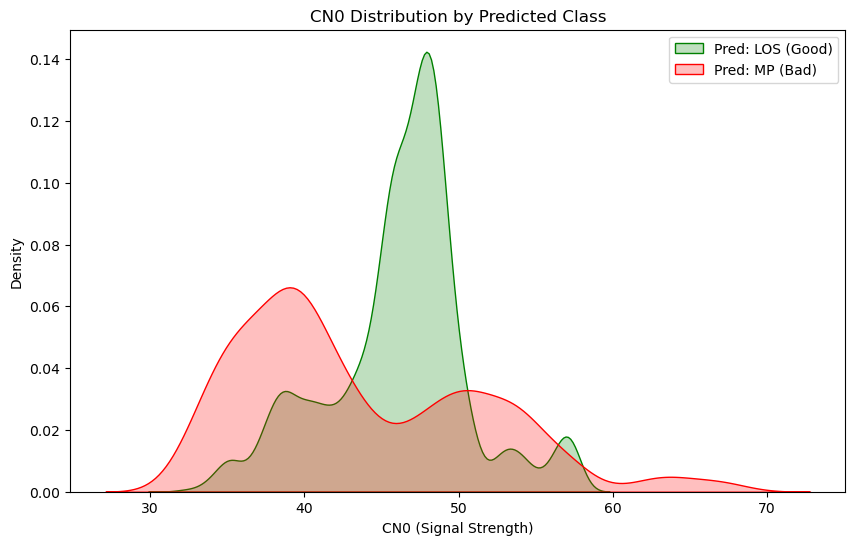

In [14]:
import pandas as pd
import numpy as np
import os
import config
import matplotlib.pyplot as plt
import seaborn as sns

def check_physics():
    # 读取结果文件
    file_path = os.path.join(config.MODEL_SAVE_DIR, "results_single_svm", "tgt_data_with_single_svm_predictions.csv")
    
    if not os.path.exists(file_path):
        print("❌ 找不到结果文件，请先运行 main_single_svm")
        return

    print(f"正在读取结果文件: {file_path} ...")
    df = pd.read_csv(file_path)
    
    # 剔除没有预测结果的行
    df = df.dropna(subset=['predicted_multipath'])
    
    print("\n" + "="*40)
    print("   物理常识检查 (Truth Check)")
    print("="*40)
    
    # 1. 分组统计
    group_0 = df[df['predicted_multipath'] == 0] # 预测为 LOS (好)
    group_1 = df[df['predicted_multipath'] == 1] # 预测为 MP (坏)
    
    print(f"预测为 好信号 (0) 的数量: {len(group_0)} ({len(group_0)/len(df):.1%})")
    print(f"预测为 坏信号 (1) 的数量: {len(group_1)} ({len(group_1)/len(df):.1%})")
    
    print("-" * 40)
    
    # 2. 检查 CN0 (信号强度) - 最硬的物理指标
    # 通常：LOS > 40, MP < 35
    cn0_0 = group_0['cn0'].mean()
    cn0_1 = group_1['cn0'].mean()
    
    print(f"【关键指标】好信号组 (0) 平均 CN0: {cn0_0:.2f} dBHz")
    print(f"【关键指标】坏信号组 (1) 平均 CN0: {cn0_1:.2f} dBHz")
    
    if cn0_0 > cn0_1 + 3:
        print("\n✅ 结论：合理。预测为'好信号'的强度确实明显更高。")
        print("      -> 可能是这批真实数据本身质量就比较好。")
    elif cn0_0 < cn0_1:
        print("\n❌ 结论：荒谬！预测为'好信号'的强度反而更低。")
        print("      -> 模型彻底学反了，或者特征提取失效。")
    else:
        print("\n⚠️ 结论：区分度不高。两组信号强度差不多。")

    # 3. 检查 Elevation (仰角)
    # 通常：高仰角更容易是 LOS
    ele_0 = group_0['elevation'].mean()
    ele_1 = group_1['elevation'].mean()
    print("-" * 40)
    print(f"好信号组 (0) 平均仰角: {ele_0:.2f} 度")
    print(f"坏信号组 (1) 平均仰角: {ele_1:.2f} 度")

    # 画图
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=group_0, x='cn0', fill=True, color='green', label='Pred: LOS (Good)')
    sns.kdeplot(data=group_1, x='cn0', fill=True, color='red', label='Pred: MP (Bad)')
    plt.title("CN0 Distribution by Predicted Class")
    plt.xlabel("CN0 (Signal Strength)")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    check_physics()